In [1]:
import os
from pathlib import Path
import pickle

import sawg.segmentation
import sawg.hpc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sawg.segmentation import get_segmentation_region, get_tiles, create_seg_run_spec, run_segmentation_on_hpc, merge_segmentation_results
from sawg.spot_table import SpotTable


/home/madeleine.hewitt/miniconda3/envs/seg_demo/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/madeleine.hewitt/miniconda3/envs/seg_demo/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/madeleine.hewitt/miniconda3/envs/seg_d

In [2]:
def get_spatial_expt_inputs(expt_path: Path, type: str, cache_file: str|None):
    if type == 'merscope':
        image_path = expt_path / 'images/'
        dt_file = expt_path / 'detected_transcripts.csv'
        inputs = {
            'image_path': image_path.as_posix(), 
            'csv_file': dt_file.as_posix(), 
            'cache_file': cache_file,
            'max_rows': None
        }
        load_func = SpotTable.load_merscope

    elif type == 'stereoseq':
        image_path = expt_path / f'Register/{name}_regist.tif'
        dt_file = expt_path / f'gem_files/{name}.tissue.gem'
        inputs = {
            'image_file': image_path.as_posix(), 
            'gem_file': dt_file.as_posix(), 
            'cache_file': cache_file,
            'skiprows': 7,
            'image_channel': 'nuclear'
        }
        load_func = SpotTable.load_stereoseq

    return inputs, load_func


def save_regions(regions, save_path):
    """Save regions as JSON in a segmentation directory."""
    path_to_regions = os.path.join(save_path, 'regions.json')
    regions_df = pd.DataFrame(regions, columns=['xlim', 'ylim'])
    regions_df.to_json(path_to_regions)


def load_regions(save_path):
    """Load previously saved regions from a segmentation directory."""
    path_to_regions = os.path.join(save_path, 'regions.json')
    regions = pd.read_json(path_to_regions).values

    return regions


def save_run_spec(run_spec, save_path):
    """Save run spec to a segmentation directory."""
    path_to_rs = os.path.join(save_path, 'run_spec.pkl')
    with open(path_to_rs, 'wb') as f:
        pickle.dump(run_spec, f)


def load_run_spec(save_path):
    """Load previously created run spec from a segmentation directory."""
    path_to_rs = os.path.join(save_path, 'run_spec.pkl')
    with open(path_to_rs, 'rb') as f:
        run_spec = pickle.load(f)

    return run_spec

## Provide input and output paths

In [3]:
barcode = 1191380492
expt_path = Path(f'/allen/programs/celltypes/production/mfish/mfishmerscopemacaqueatlas/{barcode}/region_0/')
cache_file = f'/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/data/cache_files/{barcode}_detected_transcripts.csv.npz'
save_path = f'/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/data/test_runs_cytoMH_MNH_20231027/{barcode}_test'
if not os.path.exists(save_path):
    os.mkdir(save_path)

## Load and tile a spot table

In [4]:
load_args, load_func = get_spatial_expt_inputs(expt_path, 'merscope', cache_file)
table = load_func(**load_args)
subtable = get_segmentation_region(table, ((3000, 3500), (4000, 4500)))
tiles, regions = get_tiles(subtable)

Loading from npz..


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# View tiles
fig, ax = plt.subplots(figsize=(15, 15))
subtable[::200].scatter_plot(ax=ax)
for tile in tiles:
    tile.plot_rect(ax=ax, color=(1, 0, 0, 0.1))

In [ ]:
# Save regions as csv - can be useful if you need to restart segmentation from here
save_regions(regions, save_path)

In [ ]:
# Optional: load previously saved regions
regions = load_regions(save_path)

## Define a segmentation method and options

In [ ]:
path_to_model = '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/cellpose_20230919_3species_merscope'

In [ ]:
seg_method = sawg.segmentation.CellposeSegmentationMethod
seg_opts = dict(options={
    'region': None,
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {
        'cyto': {'channel': 'total_mrna', 'n_planes': 7}, 
        'nuclei': {'channel': 'DAPI'}
    }, 
    'cellpose_options': {
        'batch_size': 8,
    },
})

## Create a segmentation run_spec to submit to the hpc

In [ ]:
tile_save_path = os.path.join(save_path, 'segmentation')
if not os.path.exists(tile_save_path):
    os.mkdir(tile_save_path)

run_spec = create_seg_run_spec(regions, load_func, load_args, seg_method, seg_opts, tile_save_path)

In [ ]:
# save run_spec: can be loaded to continue steps when stuff isn't in memory anymore
save_run_spec(run_spec, save_path)

In [ ]:
# Submit jobs
job_path = os.path.join(save_path, 'hpc-jobs')
if not os.path.exists(job_path):
    os.mkdir(job_path)

jobs = run_segmentation_on_hpc(
    run_spec,
    '/home/madeleine.hewitt/miniconda3/envs/seg_demo/',
    'localhost',
    job_path,
)

In [ ]:
# Check jobs
jobs.state()

## Merge results of tiled segmentation

In [5]:
# Optional: load run_spec from previous run
run_spec = load_run_spec(save_path)

In [6]:
# Note that this function will modify your spot table in place (adding cell_ids)
# tiles argument is optional here - if not provided, will use regions in run_spec
cell_ids, merge_results, skipped = merge_segmentation_results(subtable, run_spec, tiles)

  0%|          | 0/9 [00:00<?, ?it/s]

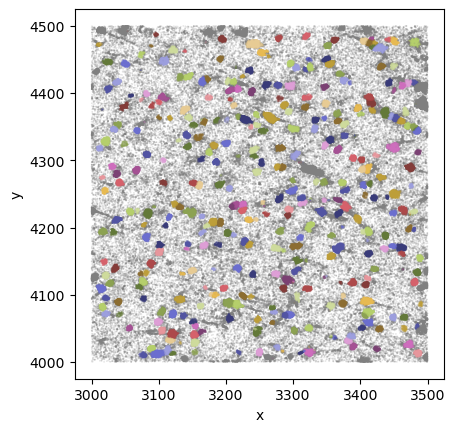

In [7]:
subtable.scatter_plot(color='cell')

In [8]:
# inspect any skipped jobs
for i in skipped:
    print(jobs[i].error)
    print(jobs[i].output)

## Save segmented cell IDs and segmentation metadata

In [9]:
# save segmented cell IDs
segmentation_file = os.path.join(save_path, 'segmentation.npy')
np.save(segmentation_file, cell_ids)
print("Saved to", segmentation_file)

Saved to /allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/data/test_runs_cytoMH_MNH_20231027/1191380492_test/segmentation.npy
